In [1]:
import numpy as np
import pydub
import matplotlib.pyplot as plt
import time

Discrete Fourier transform: $$M_{kn}=e^\frac{−i*2π*k*n}{N}$$

In [2]:
def DFT(x, N): #slow: O(N^2)
    x = np.asarray(x, dtype = float)
    
    n = np.arange(N)
    k = n.reshape(N, 1)
    
    M = np.exp(-1j * 2 * np.pi * k * n / N)
    
    return M

In [3]:
def FFT(x): #fast: O(Nlog(N))
    N = x.shape[0]
    half = int(N/2)
    
    #even
    even = np.zeros(half,dtype=np.complex_)
    for i in range(half):
        even[i] = x[2*i]
    even_part = FFT(even)
    
    #odd
    odd = even
    for i in range(half):
        odd[i] = x[2*i + 1]
    odd_part = FFT(odd)
    
    #merging
    final = np.zeros(half,dtype=np.complex_)
    for i in range(half):
        power = -2 * i * np.pi / N
        w_power = np.cos(power) + j*np.sin(power)
        final[i] = even_part[i] + w_power * odd_part[i]
        final[i + half] = even_part[i] - w_power * odd_part[i]
    
    return final

In [4]:
def vector_FFT(complex_input):
    complex_input = np.asarray(complex_input, dtype=float)
    N = complex_input.shape[0]
    
    if np.log2(N) % 1 != 0:
        print("o nono")
        
    min_N = min(N, 32)
    
    x = np.dot(DFT(complex_input, min_N), complex_input.reshape((min_N, -1)))
    
    while x.shape[0] < N:
        first_half = x[:, :x.shape[1]/2]
        second_half = x[:, x.shape[1]/2:]
        factor = np.exp(-1j * np.pi * np.arange(x.shape[0]) / x.shape[0])[:, None]
        x = np.vstack([first_half + factor * second_half, first_half - factor * second_half])
        
    return complex_input.ravel()

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


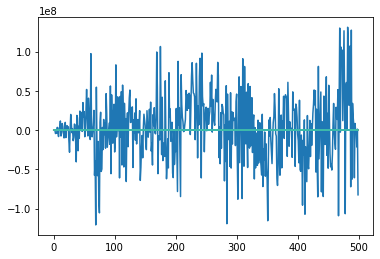

In [5]:
path = "./songs/epic.mp3"
sound = pydub.AudioSegment.from_mp3(path)
song = np.array(sound.get_array_of_samples())

if sound.channels == 2:
        song = song.reshape((-1, 2))

size = song.shape[0]
chunk_size = 4000 #4kHz is best for bins
sampled_chunk_size = int(size/chunk_size)

sampled = np.zeros(shape=(sampled_chunk_size, chunk_size), dtype=np.complex_)

for i in range(sampled_chunk_size):
    time_variations = np.zeros(chunk_size, dtype=np.complex_)

    for j in range(chunk_size):
        time_variations[j] = complex(song[i * chunk_size + 1][0], 0)
#         print(time_variations[j])
        
    sampled[i] = np.fft.fft(time_variations)
# print(sampled)
plt.plot(sampled[:500, :])
plt.show()

The most distinguishable frequencies when it comes to fingerprinting are those between low C (or C1: 32.70Hz) and high C (C8: 4186.01Hz). So the best frequencies are 30Hz - 40Hz, 40Hz - 80Hz and 80Hz - 120Hz for the low tones (e.g. bass guitar), and 120Hz - 180Hz and 180Hz - 300Hz for the middle and higher tones (vocals and most of the other instruments).

In [6]:
FREQUENCIES = [40, 80, 120, 180, 300]

In [7]:
def get_range_of_frequency(frq):
    return max(list(range(len(FREQUENCIES))), key = lambda x: FREQUENCIES[x] > frq)

In [8]:
get_range_of_frequency(100)

2

In [13]:
peaks = np.zeros(shape=(sampled_chunk_size, 5), dtype=np.int64)
highest = np.zeros(shape=(sampled_chunk_size, 5))

In [14]:
def fingerprint_hash(v1, v2, v3, v4):
#     print(v1, " ", v2, " ", v3, " ", v4)
    fingerpint = v4*1000000000 + v3*1000000 + v2*1000 + v1
#     print("fingerprint", fingerpint.astype(np.int64))
    return fingerpint

In [15]:
def point_position(number, pos=2):
    while(number < 10**pos):
        number*=10
    num = number.astype(np.int64)
#     print("number: ", num)
    return num

2085


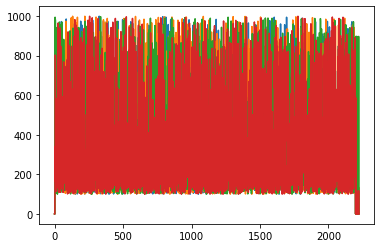

2223


In [16]:
hashing = np.zeros(shape=sampled.shape[0], dtype=np.int64)
unique = []

for i in range(0, sampled.shape[0]):
    for frq in range(40, 300):
        magnitude = np.log(np.abs(sampled[i][frq])+1)
#         print(np.log2(np.abs(sampled[i][frq])+1))
        range_index = get_range_of_frequency(frq)
#         print("magnitude: ", magnitude)
#         print("highest: ", highest[i][range_index])

        if magnitude > highest[i][range_index]:
            highest[i][range_index] = frq
            peaks[i][range_index] = point_position(magnitude.astype(float))
#             print("range: ", range_index)

    hashing[i] = fingerprint_hash(peaks[i][1], peaks[i][2], peaks[i][3], peaks[i][4])
    unique.append((peaks[i][1], peaks[i][2], peaks[i][3], peaks[i][4]))
# plt.hist(hashing)
print(len(list(set(unique))))
plt.plot(unique)
plt.show()
print(len(hashing))
# for i in range(len(hashing)):
#     print(hashing[i])